# Load the ad and non_ad creatives datasets and label them correctly.

In [1]:
import os
import cv2
import numpy as np

def load_images_from_dir(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(directory, filename))
            # Resizing 
            img = cv2.resize(img, (224, 224))
            img = img.astype(np.float32) / 255.0
            images.append(img)
            # Assign label
            labels.append(label)
    return np.array(images), np.array(labels)

# Directory paths for ads and non-ads images
ad_creatives_dir = "C:\\Users\\ilamu\\Downloads\\Images\\Images\\Advertising Images"
non_ad_creatives_dir = "C:\\Users\\ilamu\\Downloads\\Images\\Images\\Non-Advertising Images"
print("Loading and labelling...")
# Load and label images
ad_images, ad_labels = load_images_from_dir(ad_creatives_dir, label="ad")
non_ad_images, non_ad_labels = load_images_from_dir(non_ad_creatives_dir, label="non-ad")

print("Combining images and labels...")
# Combine images and labels
all_images = np.concatenate((ad_images, non_ad_images), axis=0)
all_labels = np.concatenate((ad_labels, non_ad_labels), axis=0)
print("Finished Combining images and labels...")

print("Shuffling data...")

# Shuffle data
indices = np.arange(all_images.shape[0])
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]
print("Finished Shuffling data...")
# Print shape of images and labels
print("Shape of all images:", all_images.shape)
print("Shape of all labels:", all_labels.shape)

Loading and labelling...
Combining images and labels...
Finished Combining images and labels...
Shuffling data...
Finished Shuffling data...
Shape of all images: (1266, 224, 224, 3)
Shape of all labels: (1266,)


# Then Augment the images in both the folders and save in separate folders.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,   
    fill_mode='nearest'     
)

def augment_images(images, output_dir):
    # Creating output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Augment and save images
    for i, image in enumerate(images):
        augmented_images = []
        image = np.expand_dims(image, axis=0)  
        for batch in datagen.flow(image, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpg'):
            augmented_images.append(batch[0])
            if len(augmented_images) >= 5:  # Augment 5 images per original image
                break

# Define output directories
output_ad_dir = "C:\\Users\\ilamu\\Downloads\\Imagess\\augmented_ad_images"
output_non_ad_dir = "C:\\Users\\ilamu\\Downloads\\Imagess\\augmented_non_ad_images"

# Augment ad images and save
augment_images(ad_images, output_ad_dir)

# Count augmented ad images
num_augmented_ad_images = sum(len(files) for _, _, files in os.walk(output_ad_dir))
print("Number of augmented ad images:", num_augmented_ad_images)

# Augment non-ad images and save
augment_images(non_ad_images, output_non_ad_dir)

# Count augmented non-ad images
num_augmented_non_ad_images = sum(len(files) for _, _, files in os.walk(output_non_ad_dir))
print("Number of augmented non-ad images:", num_augmented_non_ad_images)


Number of augmented ad images: 4645
Number of augmented non-ad images: 2863


# Balance the augmented images by deleting the excess images.

In [3]:
def count_images_in_folder(folder):
    # Count the number of images in the folder
    files = os.listdir(folder)
    return len(files)

def balance_augmented_images(folder1, folder2):
    # Get the list of files in each folder
    files1 = os.listdir(folder1)
    files2 = os.listdir(folder2)
    
    # Calculate the difference in the number of files
    diff = len(files1) - len(files2)
    
    # Determine which folder has more images
    if diff > 0:
        # Delete excess images from folder1
        for i in range(diff):
            os.remove(os.path.join(folder1, files1[i]))
        print(f"Deleted {diff} excess images from {folder1}.")
    elif diff < 0:
        # Delete excess images from folder2
        for i in range(-diff):
            os.remove(os.path.join(folder2, files2[i]))
        print(f"Deleted {-diff} excess images from {folder2}.")
    else:
        print("Both folders have an equal number of images.")

# Specify the paths to the augmented image folders
folder1 = "C:\\Users\\ilamu\\Downloads\\Imagess\\augmented_ad_images"
folder2 = "C:\\Users\\ilamu\\Downloads\\Imagess\\augmented_non_ad_images"

# Balance the augmented images
balance_augmented_images(folder1, folder2)

# Count the number of images in each folder after balancing
num_images_folder1 = count_images_in_folder(folder1)
num_images_folder2 = count_images_in_folder(folder2)

# Display the number of images in each folder
print(f"Number of augmented images in {folder1}: {num_images_folder1}")
print(f"Number of augmented images in {folder2}: {num_images_folder2}")
print(f"Total number of augmented images: {num_images_folder1 + num_images_folder2}")


Deleted 1782 excess images from C:\Users\ilamu\Downloads\Imagess\augmented_ad_images.
Number of augmented images in C:\Users\ilamu\Downloads\Imagess\augmented_ad_images: 2863
Number of augmented images in C:\Users\ilamu\Downloads\Imagess\augmented_non_ad_images: 2863
Total number of augmented images: 5726


# Split the augmented images into training and testing data.

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Directory paths for augmented ad and non-ad images
augmented_ad_dir = "C:\\Users\\ilamu\\Downloads\\Imagess\\augmented_ad_images"
augmented_non_ad_dir = "C:\\Users\\ilamu\\Downloads\\Imagess\\augmented_non_ad_images"

# Load augmented ad images and labels
augmented_ad_images, augmented_ad_labels = load_images_from_dir(augmented_ad_dir, label="ad")
# Load augmented non-ad images and labels
augmented_non_ad_images, augmented_non_ad_labels = load_images_from_dir(augmented_non_ad_dir, label="non-ad")

# Combine augmented images and labels
X_augmented = np.concatenate((augmented_ad_images, augmented_non_ad_images), axis=0)
y_augmented = np.concatenate((augmented_ad_labels, augmented_non_ad_labels), axis=0)

# Encode labels
label_encoder = LabelEncoder()
y_encoded_augmented = label_encoder.fit_transform(y_augmented)

# Perform train-test split
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(X_augmented, y_encoded_augmented, test_size=0.2, random_state=42)

# Print shapes of train and test sets
print("Shape of X_train_augmented:", X_train_augmented.shape)
print("Shape of y_train_augmented:", y_train_augmented.shape)
print("Shape of X_test_augmented:", X_test_augmented.shape)
print("Shape of y_test_augmented:", y_test_augmented.shape)



Shape of X_train_augmented: (4580, 224, 224, 3)
Shape of y_train_augmented: (4580,)
Shape of X_test_augmented: (1146, 224, 224, 3)
Shape of y_test_augmented: (1146,)


# Load the base model ResNet50

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model with custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with better optimization algorithm(here. Adam optimizer)

In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define the learning rate schedule
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

learning_rate_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True
)

# Define the optimizer with the learning rate schedule
optimizer = Adam(learning_rate=learning_rate_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train the compiled model.

In [7]:
# Now training the model with augmented data
history = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=1,  
    batch_size=32,  
    validation_data=(X_test_augmented, y_test_augmented),
    verbose=1
)

# After training, we can evaluate the model on our test data
loss, accuracy = model.evaluate(X_test_augmented, y_test_augmented)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


144/144 ━━━━━━━━━━━━━━━━━━━━ 547s 4s/step - accuracy: 0.6669 - loss: 0.6271 - val_accuracy: 0.7661 - val_loss: 0.4729
36/36 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.7368 - loss: 0.4921
Test Loss: 0.4729458689689636
Test Accuracy: 0.7661430835723877


# Visualize the model's evaluation metic and infer

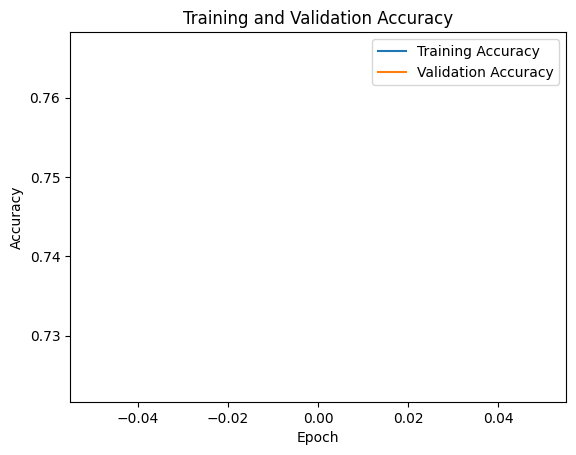

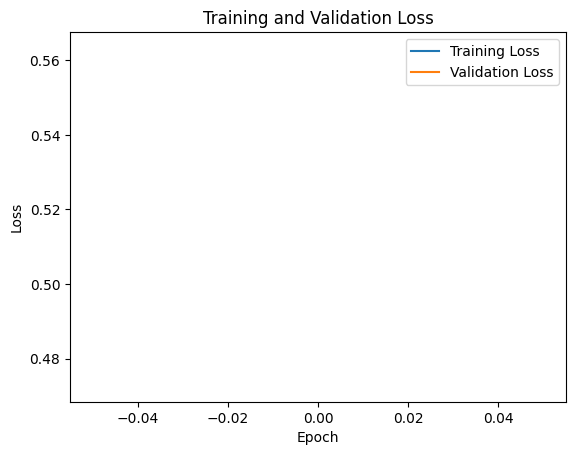

In [8]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Save the model

In [11]:
from tensorflow.keras.models import save_model, load_model

# Save the trained model
model.save('C:\\Users\\ilamu\\Downloads\\Imagess\\ads_classifier_model.keras')
print("Model Saved...")
# Load the saved model
loaded_model = load_model('C:\\Users\\ilamu\\Downloads\\Imagess\\ads_classifier_model.keras')
print("Model Loaded...")

Model Saved...
Model Loaded...


# Test the trained model with different samples. Here we took 5 samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


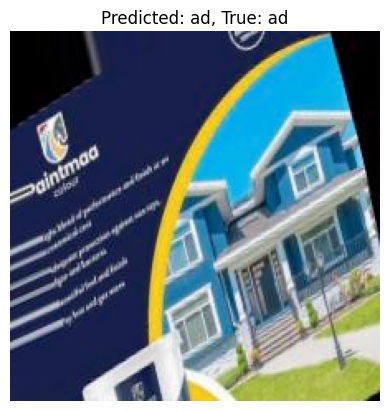

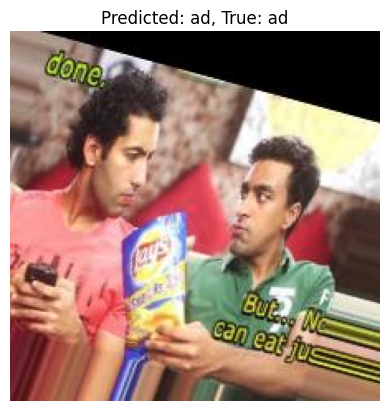

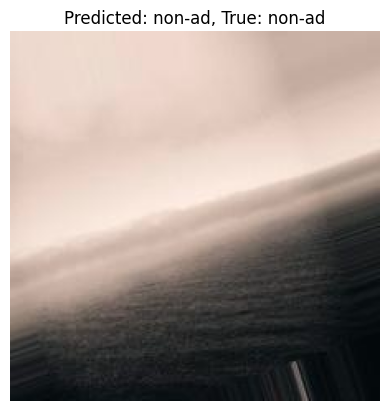

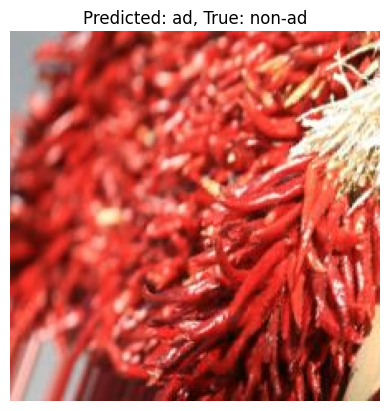

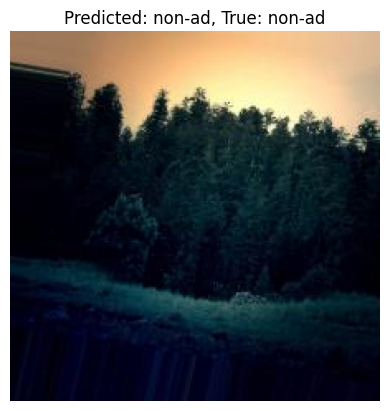

Evaluation Metrics:
Accuracy: 0.8
Precision: 1.0
Recall: 0.6666666666666666
F1-score: 0.8
Confusion Matrix:
[[2 0]
 [1 2]]


In [12]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the saved model
loaded_model = load_model('C:\\Users\\ilamu\\Downloads\\Imagess\\ads_classifier_model.keras')

# Sample images for prediction
sample_indices = np.random.choice(X_test_augmented.shape[0], size=5, replace=False)
sample_images = X_test_augmented[sample_indices]
sample_labels = y_test_augmented[sample_indices]

# Predictions using the loaded model
predictions = loaded_model.predict(sample_images)
predicted_labels = (predictions > 0.5).astype(int)

# Display sample images with true and predicted labels
for i in range(len(sample_indices)):
    plt.imshow(sample_images[i])
    plt.title(f"Predicted: {'non-ad' if predicted_labels[i] == 1 else 'ad'}, True: {'non-ad' if sample_labels[i] == 1 else 'ad'}")
    plt.axis('off')
    plt.show()

# Calculate evaluation metrics
accuracy = accuracy_score(sample_labels, predicted_labels)
precision = precision_score(sample_labels, predicted_labels)
recall = recall_score(sample_labels, predicted_labels)
f1 = f1_score(sample_labels, predicted_labels)
conf_matrix = confusion_matrix(sample_labels, predicted_labels)

# Display evaluation metrics
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


# Test with any images by getting as input from the user.

In [29]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import Image

# Function to preprocess the uploaded image
def preprocess_image(image):
    nparr = np.frombuffer(image, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    return img

# Function to predict whether the image is an ad or not
def predict_ad_or_not(model, processed_image):
    input_image = np.expand_dims(processed_image, axis=0)
    prediction = model.predict(input_image)
    predicted_label = "Non-ad" if prediction > 0.5 else "Ad"
    return predicted_label

# Load the saved model
model = load_model('C:\\Users\\ilamu\\Downloads\\Imagess\\ads_classifier_model.keras')

# Create a file upload widget
uploader = widgets.FileUpload(
    accept='.jpg,.jpeg,.png',  # Limit file types to images
    multiple=False  # Allow only single file selection
)

# Create a button for predicting the uploaded image
predict_button = widgets.Button(description="Predict")

# Create an output widget for displaying the result
output = widgets.Output()

# Function to handle the predict button click event
def on_predict_click(button):
    with output:
        clear_output(wait=True)
        if uploader.value:
            uploaded_file_content = uploader.value[0]['content']
            processed_image = preprocess_image(uploaded_file_content)
            predicted_label = predict_ad_or_not(model, processed_image)
            display(Image(data=uploaded_file_content, format='png'))
            print("Predicted Label:", predicted_label)
        else:
            print("Please upload an image first.")

# Register the event handler for predict button click
predict_button.on_click(on_predict_click)

# Display the file upload widget and predict button
display(uploader)
display(predict_button)
display(output)


FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Upload')

Button(description='Predict', style=ButtonStyle())

Output()